In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace as NS
from os.path import join
import yaml
import torch
import torch.nn as nn
from syngan.models import OjaNet, OjaRule, LocalMLP, ModuleWrapper
from syngan.post_hoc_analysis import (load_network_from_checkpoint as load,
                                      make_new_data, insets)


## Load data and fits

In [3]:
## ----------------------------------- Data -----------------------------------------
# Path to data
path_to_data_3 = join("..", "..", "data", "oja_net_small")
path_to_data_noise = join("..", "..", "data", "oja_net_noise_small")
path_to_data_39 = join("..", "..", "data", "oja_net_big")

# Load config
with open(join(path_to_data_3, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

# Load test data for 3 pre-syn neur; no noise
test_data_3 = np.load(join(path_to_data_3, "extra_test_data.npz"))
X3, Y3, PCs3, weights3, scores3 = test_data_3["presyn_act"], test_data_3["postsyn_act"],\
test_data_3["presyn_pcs"], test_data_3["weights"], test_data_3["scores"]

# Load test data for 3 pre-syn neur; with added noise
test_data_noise = np.load(join(path_to_data_noise, "test_data.npz"))
Xn, Yn, PCsn, weightsn, scoresn = test_data_noise["presyn_act"], test_data_noise["postsyn_act"],\
test_data_noise["presyn_pcs"], test_data_noise["weights"], test_data_noise["scores"]

# Load test data for 39 pre-syn neur; no noise
test_data_39 = np.load(join(path_to_data_39, "test_data.npz"))
X39, Y39, PCs39, weights39, scores39 = test_data_39["presyn_act"], test_data_39["postsyn_act"],\
test_data_39["presyn_pcs"], test_data_39["weights"], test_data_39["scores"]

# Make GT net
gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [4]:
## ----------------------------------- Load fits -------------------------------------------
prefix = ".."

path_to_fits = {"small-supervised": prefix + "oja_net_small/<>",
                "noise_small-supervised": prefix + "oja_net_noise_small/<>",
                "big-supervised": prefix + "oja_net_big/<>",
               }

generators = {k: load(path,
                      "oja_net_small",
                      path_to_sim_conf="../../data/oja_net_%s/" % k.split("-")[0],
                      path_to_fit_conf="../tasks/oja_net_%s/" % k.split("-")[0])
             for k, path in path_to_fits.items()
             }


# Copy Local MLP parameters from 39 presyn fit to Local MLP with 3 presyn inputs
temp1 = generators["big-supervised"]
rule1 = LocalMLP([nn.Linear(3, 100, bias=False),
                  nn.Sigmoid(),
                  nn.Linear(100, 100, bias=False),
                  nn.Sigmoid(),
                  nn.Linear(100, 1, bias=False),
                  ModuleWrapper(torch.reshape,
                                shape=(-1,
                                       3, 1))],
                3, 1)

for p1, pp1 in zip(rule1.parameter.parameters(),
                   temp1.update_rule.parameter.parameters(),
                   ):
    p1.data = pp1.data

generators["big-supervised"]= OjaNet(rule1)
generators["gt"] = gt_net


## Make new data

In [7]:
## -----------------------------------  Make new data -----------------------------------

# Make new out-of-distribution data
test_wts = {}
test_outputs = {}
test_score = {}

torch.manual_seed(786)
random_wts = 1e-1 * torch.abs(torch.randn(len(X3), 1, 3, 1))
dataset = 0
for k in ["gt", "small-supervised"]:
    print(k)
    net = "OjaNet"
    X = X3
    PCs = PCs3
    n_presyn_neurs = 3
    n_postsyn_neurs = 1
    timesteps = 200
    update_rate = 0.1

    wts, y, score = make_new_data(net="OjaNet",
                                  rule=generators[k].update_rule,
                                  presyn_act=X,
                                  wt_init_seed=786,
                                  init_weights=random_wts,
                                  return_score=True,
                                  score_funcn="pc_norm",
                                  PCs=PCs,
                                  n_presyn_neurs=n_presyn_neurs,
                                  n_postsyn_neurs=n_postsyn_neurs,
                                  timesteps=timesteps,
                                  update_rate=update_rate
                                 )

    test_wts[k] = wts
    test_outputs[k] = y
    test_score[k] = score


gt
small-supervised


In [8]:
# Make new noise data
torch.manual_seed(786)
random_wts_n = 1e-1 * torch.abs(torch.randn(1, 1, 3, 1))
dataset_noise = 2

for k in ["gt", "noise_small-supervised"]:
    print(k)
    X = Xn[dataset_noise:dataset_noise+1]
    PCs = PCsn[dataset_noise:dataset_noise+1]

    wts, y, score = make_new_data(net="OjaNet",
                                  rule=generators[k].update_rule,
                                  presyn_act=X,
                                  init_weights=random_wts_n,
                                  return_score=True,
                                  score_funcn="pc_norm",
                                  PCs=PCs,
                                  noise_amplitude=0.25
                                  )
    if "gt" in k:
        key = "gt_noise_small"

    else:
        dict_str = k.split("-")
        key = dict_str[0] + "_train-" + dict_str[1]

    test_wts[key] = wts
    test_outputs[key] = y
    test_score[key] = score


gt
noise_small-supervised


In [10]:
# Make new 39 presyn data
torch.manual_seed(786)
random_wts_39 = 1e-1 * torch.abs(torch.randn(1, 1, 39, 1))
dataset_big = 2

for k, rule in zip(["gt", "big-supervised"],
                   [OjaRule(39, 1), temp1.update_rule]):
    print(k)
    X = X39[dataset_big:dataset_big+1]
    PCs = PCs39[dataset_big:dataset_big+1]

    wts, y, score = make_new_data("OjaNet",
                                  rule,
                                  presyn_act=X,
                                  init_weights=random_wts_39,
                                  wt_init_seed=786,
                                  return_score=True,
                                  score_funcn="pc_norm",
                                  PCs=PCs,
                                  n_presyn_neurs=39,
                                  n_postsyn_neurs=1,
                                  timesteps=200
                                  )
    if "gt" in k:
        key = "gt_big"

    else:
        dict_str = k.split("-")
        key = dict_str[0] + "_train-" + dict_str[1]

    test_wts[key] = wts
    test_outputs[key] = y
    test_score[key] = score


gt
big-supervised


## Set figure properties

In [15]:
# Set general properties for figure
labels = {"gt": "Oja's Rule",
          "small-supervised": r"MSE: $y$=Noiseless, $N=3$",
          "noise_small_train-supervised": r"MSE: $y$=Noisy, $N=3$",
          "big_train-supervised": r"MSE: $y$=Noiseless, $N=39$",}
colors = {"gt": "k",
          "small-supervised": "xkcd:azure",
          "noise_small_train-supervised": "xkcd:olive",
          "big_train-supervised": "#FFC0CB"}

timebins = [9, 49, 199]


## Make figure

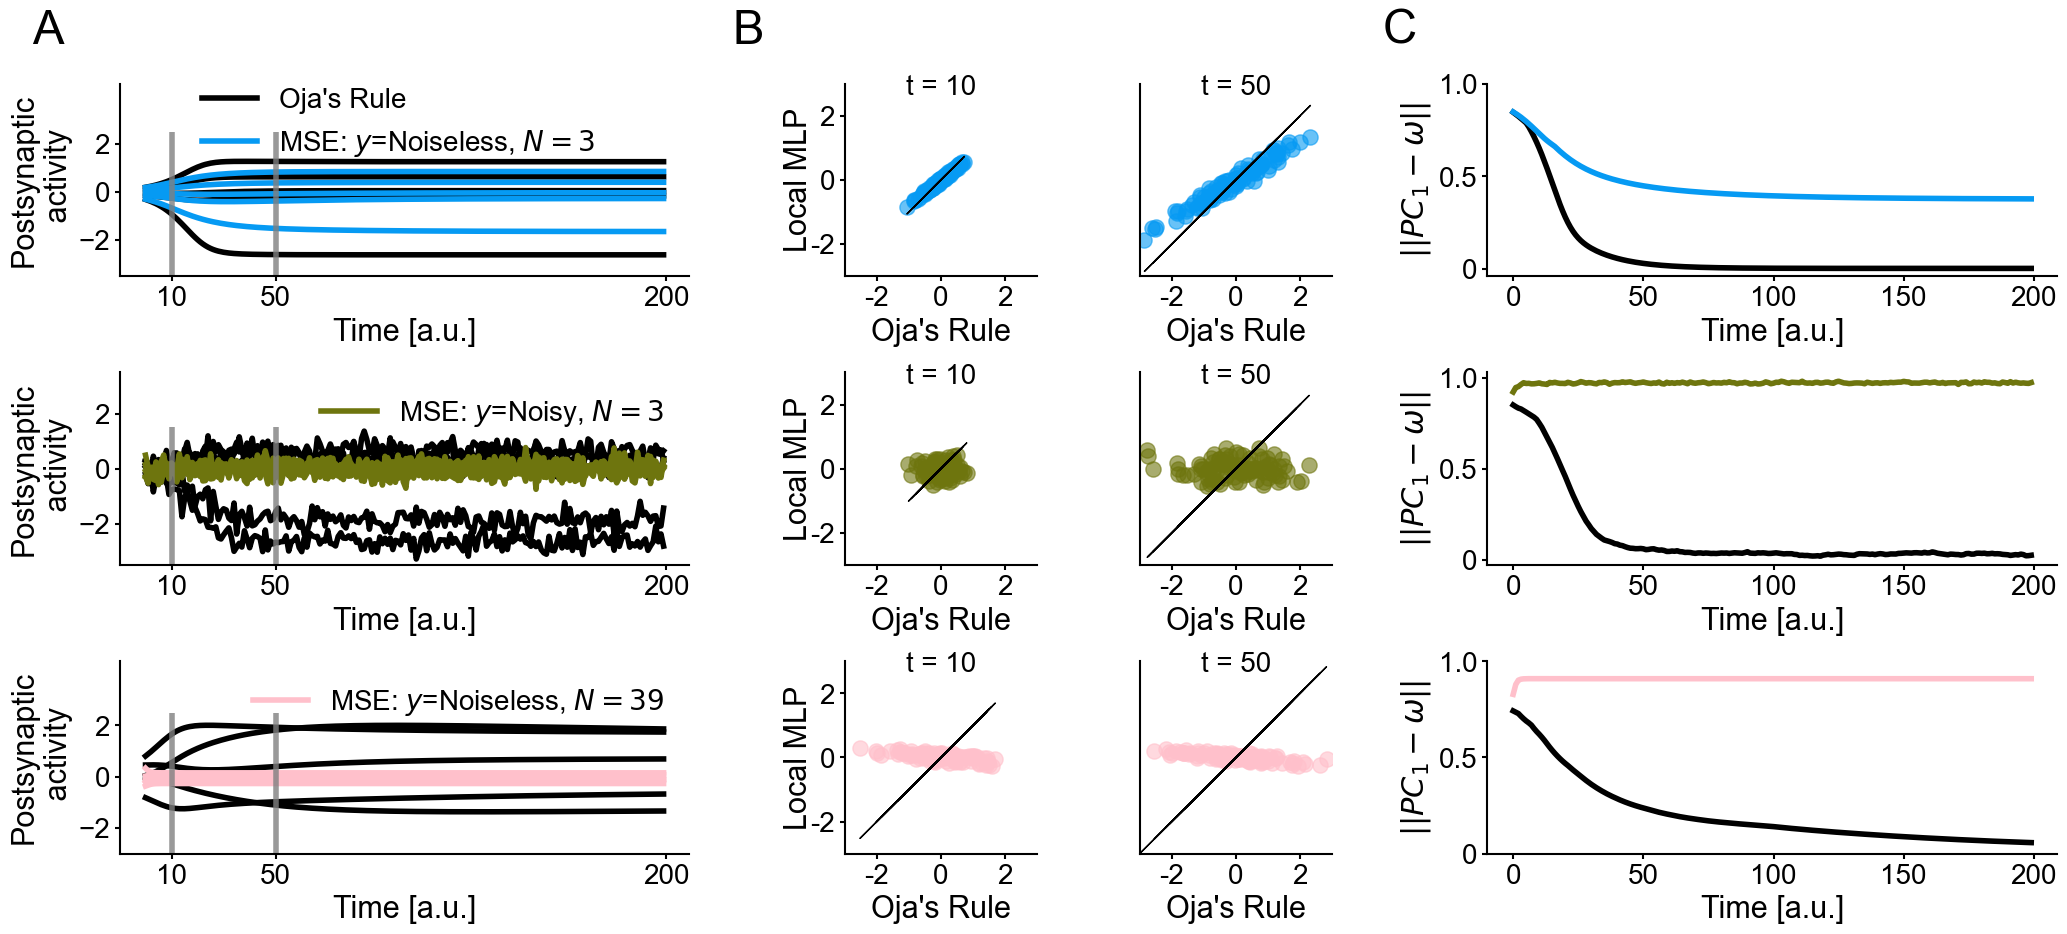

In [26]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig = plt.figure(figsize=(25, 10))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.2, hspace=.5)
    fig.tight_layout()

    gs = plt.GridSpec(3, 3, width_ratios=(2., 2, 2), height_ratios=(1., 1., 1.))

    # Panel traces
    for i, net_type, gt_type, lim in zip([0, 1, 2],
                                          ["small-supervised",
                                           "noise_small_train-supervised",
                                           "big_train-supervised"],
                                          ["gt", "gt_noise_small", "gt_big"],
                                          [[-3.5, 4.5], [-3.5, 3.5], [-3., 4.5]]
                                                ):
        ax = plt.subplot(gs[i * 3])

        ax.plot(test_outputs[gt_type][dataset, 5:10].squeeze().T,
                  lw=4.,
                  color=colors["gt"])
        ax.plot(test_outputs[net_type][dataset, 5:10].squeeze().T,
                  lw=4,
                  color=colors[net_type],
                  )
        ax.vlines([t+1 for t in timebins[:-1]],
                  ymin=lim[0], ymax=lim[1]-2, color="grey", lw=4, alpha=.8)

        ax.set_ylim(lim)
        ax.set_yticks([-2, 0, 2], fontsize=20)
        ax.set_xticks([10, 50, 200], fontsize=20)
        ax.set_xlabel("Time [a.u.]", fontsize=22)
        ax.set_ylabel("Postsynaptic\n activity", fontsize=22)

        ax.plot([], [], color=colors["gt"], label=labels["gt"] if i==0 else "", lw=4)
        ax.plot([], [], color=colors[net_type], label=labels[net_type], lw=4)
        if i == 0:
            ax.legend(fontsize=20, loc="upper left", bbox_to_anchor=(0.1, 1.11))
        else:
            ax.legend(fontsize=20, loc="best")


    # Panel traces scatter plots
    for i, net_type, gt_type in zip([0, 1, 2],
                                          ["small-supervised",
                                           "noise_small_train-supervised",
                                           "big_train-supervised"],
                                          ["gt", "gt_noise_small", "gt_big"],
                                                ):
        ax = plt.subplot(gs[i * 3 + 1])
        ax.axis('off')
        for j, (t, loc) in enumerate(zip(timebins[:-1], ["left", "right"])):
            div = make_axes_locatable(ax)
            axx = div.append_axes(loc, size="100%", pad=.2)
            insets(axx, t, net_type, 0,
                   colors=colors,
                   labels=net_type,
                   test_outputs=test_outputs,
                   ylabel="Local MLP",
                   fontsize=20,
                   labelsize=22,
                   gt_key=gt_type)

    # Panel weight trajectories
    for i, net_type, gt_type in zip([0, 1, 2],
                                          ["small-supervised",
                                           "noise_small_train-supervised",
                                           "big_train-supervised"],
                                          ["gt", "gt_noise_small", "gt_big"],
                                                ):
        ax = plt.subplot(gs[i * 3 + 2])

        ax.plot(test_score[gt_type][dataset].squeeze().T,
                     color=colors["gt"],
                     lw=4,
                     alpha=1.)

        ax.plot(test_score[net_type][dataset].squeeze().T,
                 color=colors[net_type],
                 lw=4,
               )

        ax.set_xlabel("Time [a.u.]", fontsize=22)
        ax.set_ylabel(r"$||PC_1 - \omega||$", fontsize=22)
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(labels=[0, 50, 100, 150, 200], fontsize=20)
        ax.set_yticks([0, .5, 1.])
        ax.set_yticklabels(labels=[0, .5, 1.], fontsize=20)

    fig.text(0.09, .92, "A", fontsize=34)
    fig.text(0.37, .92, "B", fontsize=34)
    fig.text(0.63, .92, "C", fontsize=34)


    fig.savefig("supp_fig_4.jpg")
